In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score
import numpy as np
from xgboost import XGBClassifier

In [2]:
df = pd.read_excel("delivery_trips.csv.xlsx")

In [3]:
df.head()

,trip_id,distance_km,estimated_duration_min,actual_duration_min,num_stops,vehicle_type,vehicle_age_years,load_weight_kg,departure_hour,day_of_week,weather_condition,region,is_late_delivery
0,1,19.35,37.2,55.9,17,van,2,118.6,15,Wed,rain,suburban,1
1,2,47.59,119.3,123.2,9,van,7,1171.4,1,Thu,clear,urban,0
2,3,36.87,110.7,102.1,2,van,13,1583.8,7,Sun,clear,urban,0
3,4,30.33,86.8,92.1,18,truck_large,5,83.7,5,Wed,rain,suburban,0
4,5,8.64,28.0,5.0,9,van,4,1121.9,15,Sun,rain,rural,0


In [4]:
# df[(df["day_of_week"]=="Sat") & (df["is_late_delivery"]==0)]

In [5]:
df.isna().sum()

trip_id                   0
distance_km               0
estimated_duration_min    0
actual_duration_min       0
num_stops                 0
vehicle_type              0
vehicle_age_years         0
load_weight_kg            0
departure_hour            0
day_of_week               0
weather_condition         0
region                    0
is_late_delivery          0
dtype: int64

It can be seen that none of the columns consist of null values. Also, if even there were any null values in "trip_id" and "actual_duration_min" (which we drop them in later cell), we could have just ignored them. This is the reason we are checking column-wise here.

In [6]:
Y = df["is_late_delivery"]

In [7]:
X = df.drop(columns=["trip_id", "actual_duration_min", "is_late_delivery"], axis=1)
X.columns

Index(['distance_km', 'estimated_duration_min', 'num_stops', 'vehicle_type',
       'vehicle_age_years', 'load_weight_kg', 'departure_hour', 'day_of_week',
       'weather_condition', 'region'],
      dtype='object')

In [8]:
X, X_test, Y, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

In [9]:
str_unique_vals = {
                    "vehicle_type": ['van', 'truck_large', 'truck_small'],
                    "day_of_week": ['Wed', 'Thu', 'Sun', 'Tue', 'Mon', 'Fri', 'Sat'],
                    "weather_condition": ['rain', 'clear', 'windy', 'snow'],
                    "region": ['suburban', 'urban', 'rural']
                  }
for col in str_unique_vals.keys():
    for each_uni in X[col].unique():
        if each_uni not in str_unique_vals[col]:
            print("Error:", col, "has", each_uni, "which is not mentioned in Take_Home_Details.pdf")


In [10]:
numerical_max_vals = {
                        "num_stops": 25,
                        "vehicle_age_years": 14,
                        "departure_hour": 23,
                        "distance_km": 50,
                        "load_weight_kg":2000
                      }
for col in numerical_max_vals.keys():
    if numerical_max_vals[col] < X[col].max():
        print("Error:", col, "has max value", X[col].max(), "which is > than", numerical_max_vals[col], "as mentioned in the Take_Home_Details.pdf")

    if X[col].min() < 0:
        print("Error:", col, "has min value", X[col].min(), "which is < 0")

## EDA
##### 1) Data quality issues and missing/invalid values:
   It can be seen in the previous cells that there are not any missing values. Also, all the values lie well within the range mentioned in the Take_Home_Details.pdf
   

In [11]:
X["estimated_duration_min"].max(), X["estimated_duration_min"].min()

(157.1, 5.0)

In [12]:
numerical_max_vals["estimated_duration_min"] = X["estimated_duration_min"].max()

estimated_duration_min is the only feature we add manually because its upper range cannot be defined.

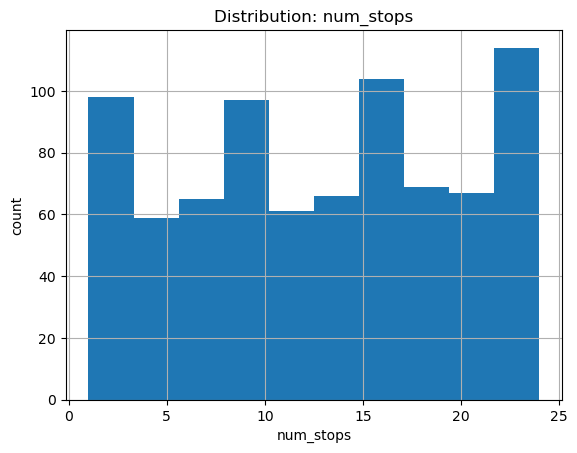

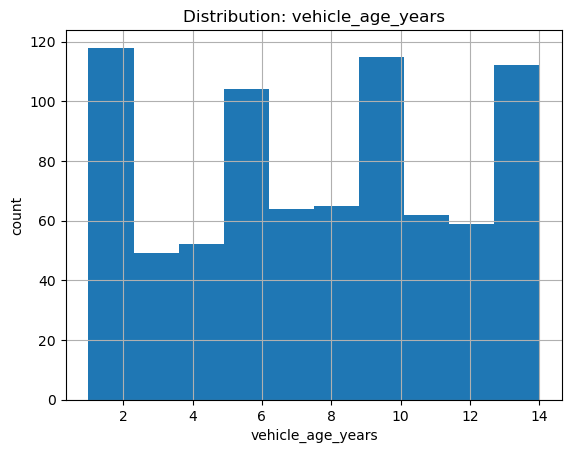

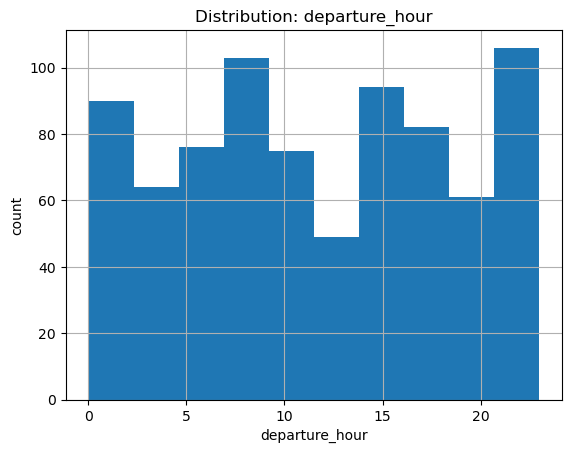

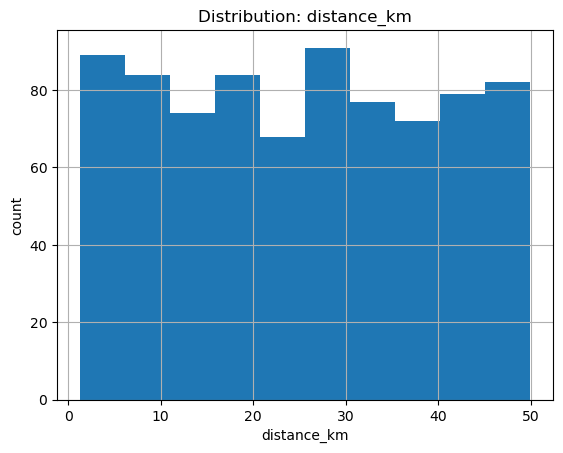

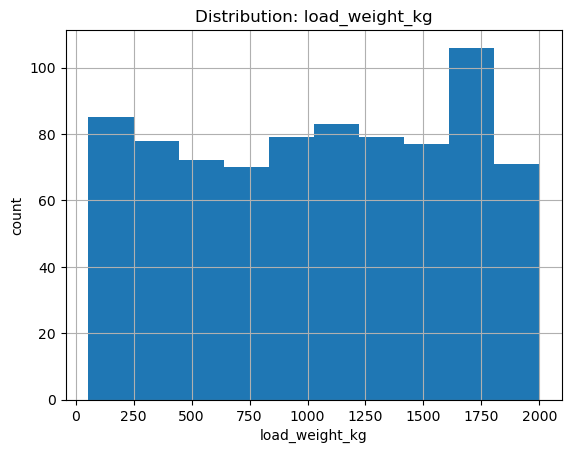

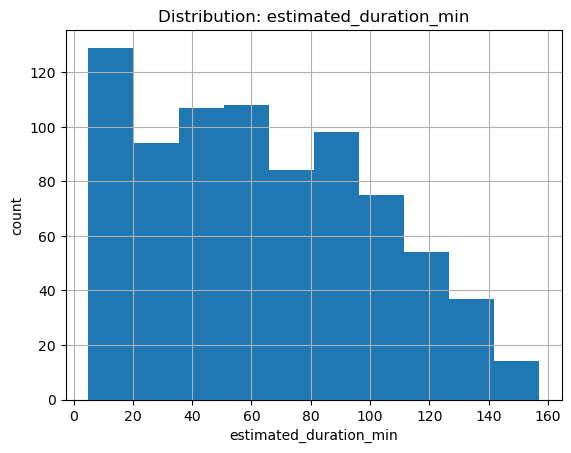

In [13]:
for col in list(numerical_max_vals.keys()):
    plt.figure()
    X[col].hist(bins=10)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

In [14]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_km,800.0,25.227075,14.233114,1.23,12.905,25.63,37.6825,49.99
estimated_duration_min,800.0,63.754250,38.219916,5.00,30.875,60.50,92.4000,157.10
num_stops,800.0,12.872500,7.010898,1.00,7.000,13.00,19.0000,24.00
vehicle_age_years,800.0,7.602500,4.018978,1.00,4.000,8.00,11.0000,14.00
load_weight_kg,800.0,1043.058125,566.463488,55.70,580.625,1056.45,1545.2250,1999.50
departure_hour,800.0,11.682500,6.894099,0.00,6.000,11.00,18.0000,23.00


##### 2) Distribution of key features:

Now, lets first talk about the numeric features. All of the five features look well balanced and are not skewed. 

However, assuming if there was a skew, here are things that we can do for numeric features:

###### Option A — Log transform (Most commonly used and great for heavy right-skew)

    df["load_weight_log"] = np.log1p(df["load_weight_kg"])

###### Option B — Yeo-Johnson (works even with zeros/negatives)

Very handy “auto” transform:

    from sklearn.preprocessing import PowerTransformer
    pt = PowerTransformer(method="yeo-johnson")
    df[numerical_max_vals.keys()] = pt.fit_transform(df[num_cols])

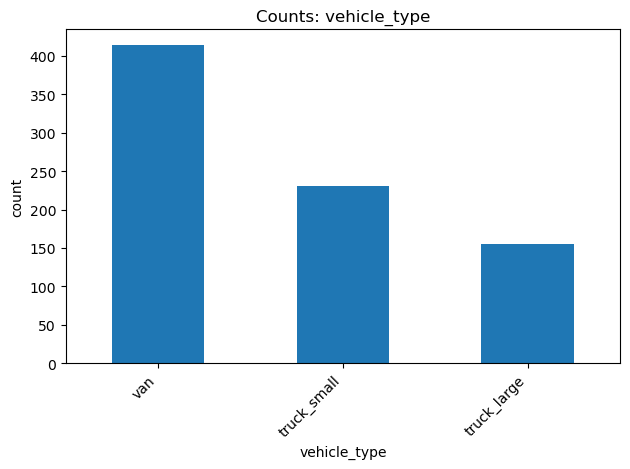

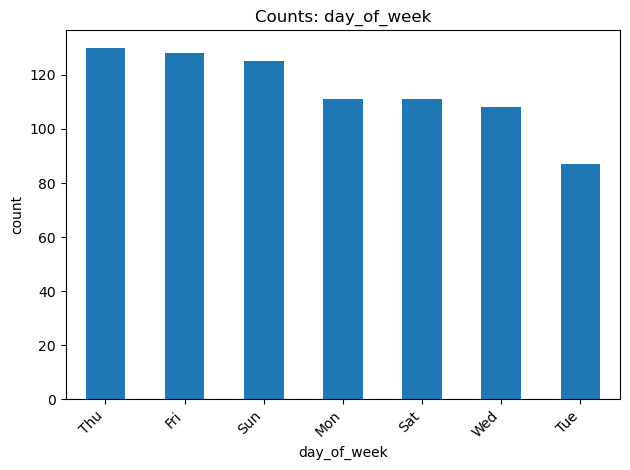

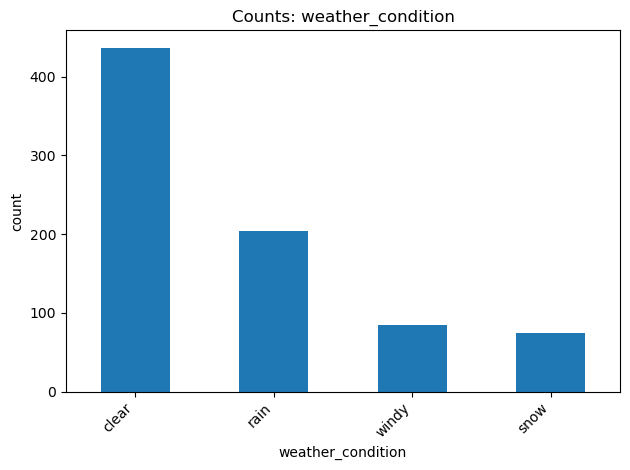

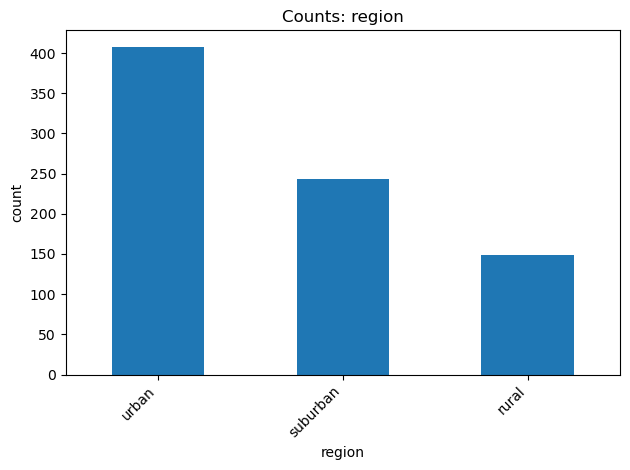

In [15]:
for col in str_unique_vals:
    vc = X[col].value_counts(dropna=False)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"Counts: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


##### 2) Distribution of key features: (Contd.)

For categorical data, we can say that the dataset is not very skewed here. Yes, we can surely see instances where "windy" and "snow" for "weather_condition" is a little less but again, its close to 20% of the "clear", thus it seems to be fine for now. 

Assuming it was really skewed, here is what we can do for categorical data:

Merge rare categories into “other”
Best default. Prevents noisy one-hot columns and overfitting.


    def lump_rare(series, min_count=350):

        vc = series.value_counts(dropna=False)
        rare = vc[vc < min_count].index
        return series.where(~series.isin(rare), other="other")

    df["weather_condition"] = lump_rare(df["weather_condition"], min_count=350)
    df["region"] = lump_rare(df["region"], min_count=150)

In [16]:
mask0 = Y.eq(0)
X_0 = X[mask0]
X_1 = X[~mask0]
X_0.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_km,619.0,27.903393,13.737425,1.45,17.4,29.01,40.02,49.99
estimated_duration_min,619.0,71.098061,37.757753,5.00,42.3,69.50,99.95,157.10
num_stops,619.0,12.852989,7.080858,1.00,7.0,13.00,19.00,24.00
vehicle_age_years,619.0,7.699515,3.985839,1.00,4.0,8.00,11.00,14.00
load_weight_kg,619.0,1047.056543,574.322044,55.70,569.6,1053.20,1566.80,1999.50
departure_hour,619.0,11.788368,6.895812,0.00,6.0,11.00,18.00,23.00


In [17]:
X_1.describe().T


,count,mean,std,min,25%,50%,75%,max
distance_km,181.0,16.074365,11.934817,1.23,6.63,12.63,23.67,46.12
estimated_duration_min,181.0,38.639227,27.743513,5.00,15.60,31.40,57.30,129.00
num_stops,181.0,12.939227,6.784923,1.00,7.00,14.00,18.00,24.00
vehicle_age_years,181.0,7.270718,4.124274,1.00,3.00,7.00,11.00,14.00
load_weight_kg,181.0,1029.383978,540.037939,62.70,605.60,1072.10,1492.30,1968.30
departure_hour,181.0,11.320442,6.895012,0.00,5.00,11.00,18.00,23.00


##### 3) Correlation relevant to on-time vs. late deliveries:

For numerical data, the means and percentiles of distance_km and estimated_duration_min are very different for X_0 and X_1

Since for X_1, the values for these two features are smaller, so we can get the fact that shorter trips / lower ETA are more likely to be "late delivery" in this dataset

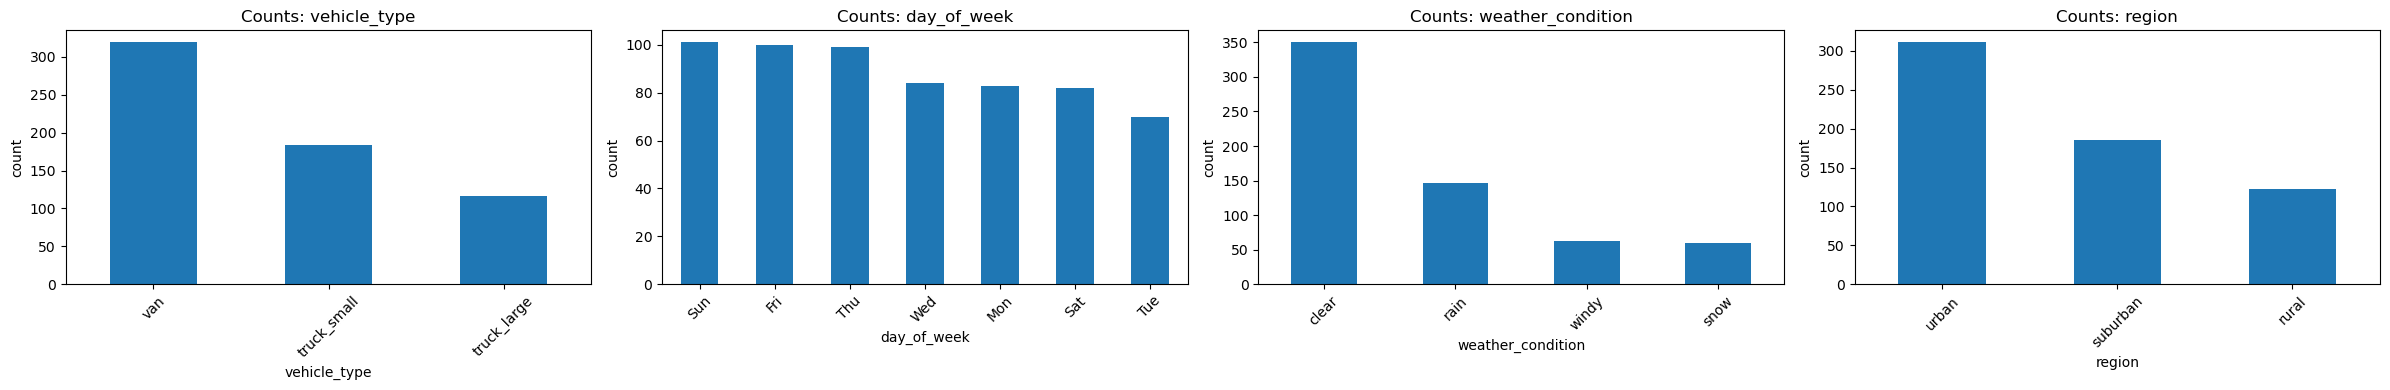

In [18]:
ncols = 4
cols = list(str_unique_vals)
nrows = math.ceil(len(cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(cols):
    vc = X_0[col].value_counts(dropna=False)

    ax = axes[i]
    vc.plot(kind="bar", ax=ax)
    ax.set_title(f"Counts: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("count")
    ax.tick_params(axis="x", rotation=45)

# hide any unused subplot slots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

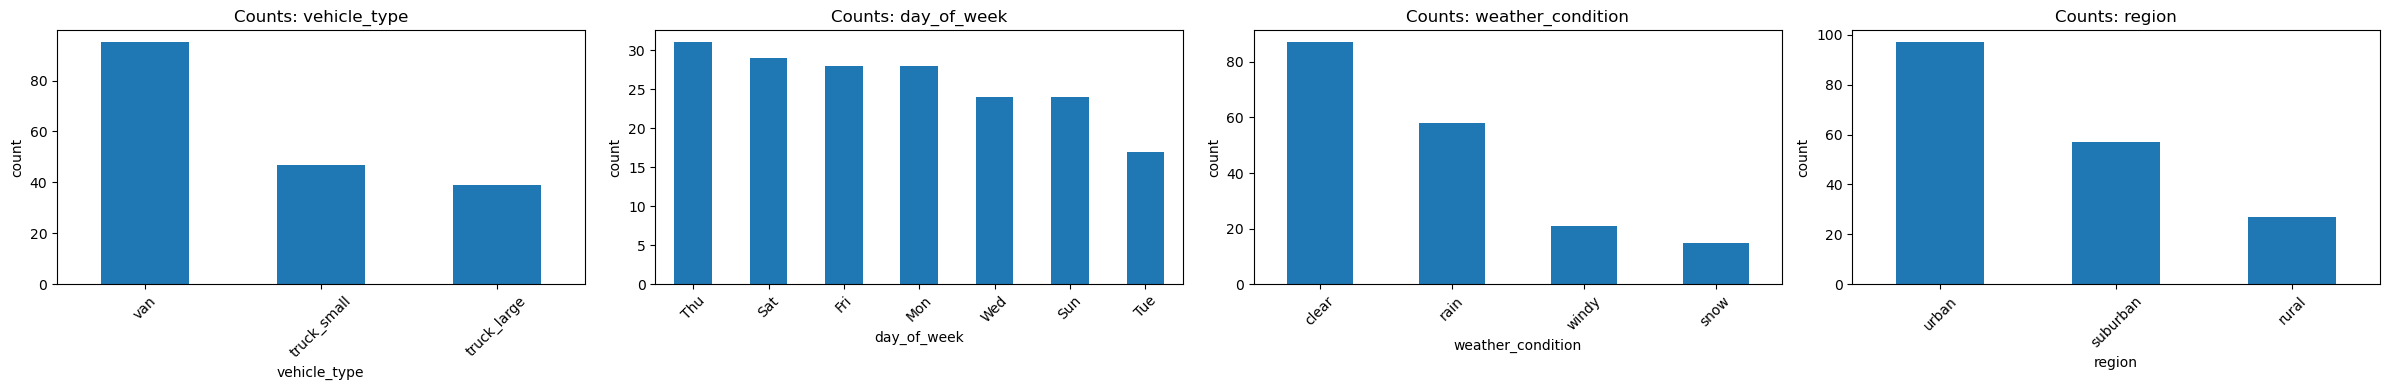

In [19]:
ncols = 4
cols = list(str_unique_vals)
nrows = math.ceil(len(cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(cols):
    vc = X_1[col].value_counts(dropna=False)

    ax = axes[i]
    vc.plot(kind="bar", ax=ax)
    ax.set_title(f"Counts: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("count")
    ax.tick_params(axis="x", rotation=45)

# hide any unused subplot slots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

##### 3) Correlation relevant to on-time vs. late deliveries: (Contd.)

For categorical data, the split between X_0 and X_1 are almost identical. Thus, we cannot have any correlation here if we just look at the bar charts of X_0 and X_1.

In [20]:
cat_summaries = {}
for col in str_unique_vals.keys():
    tab = (
        df.groupby(col)["is_late_delivery"]
          .agg(count="count", late_rate="mean")
          .sort_values("late_rate", ascending=False)
          .round(3)
    )
    cat_summaries[col] = tab
    print(f"\nLate rate by {col}:")
    display(tab)


Late rate by vehicle_type:


,count,late_rate
vehicle_type,,
van,511,0.235
truck_large,205,0.224
truck_small,284,0.211



Late rate by day_of_week:


,count,late_rate
day_of_week,,
Mon,132,0.273
Wed,132,0.250
Sat,140,0.236
Thu,161,0.230
Fri,161,0.217
Sun,154,0.195
Tue,120,0.183



Late rate by weather_condition:


,count,late_rate
weather_condition,,
rain,268,0.291
windy,99,0.242
clear,543,0.201
snow,90,0.167



Late rate by region:


,count,late_rate
region,,
urban,515,0.231
suburban,290,0.231
rural,195,0.205


##### 3) Correlation relevant to on-time vs. late deliveries: (Contd.)
For the categorical data, we can clearly see that when its rain and windy, its more likely to be late. Also, Monday has highest chance of delay than any other day 

##### 4) Any insights that help form modeling decisions

Strongest predictors are:

1) estimated_duration_min and distance_km
2) num_stops, load_weight_kg, departure_hour ~ near zero correlation
3) Class imbalance: so direct use of accuracy makes no sense. Because,

    Late rate is ~22.6%, even a model which predicts "On-time" for every instance will get 77.4% accuracy.

    Modeling implication:

    Use Precision/Recall, F1, PR-AUC (and show confusion matrix at a chosen threshold).

    Use class_weight="balanced" for logistic regression / linear models; for tree/boosting, use appropriate class weights / scale_pos_weight.

In [21]:
# A VERY BRUTE FORCE WAY WOULD BE TO REPLACE CATEGORICAL STRING VALUES WITH NUMBERS

# for col in str_unique_vals.keys():
#     X[col] = X[col].apply(lambda x: str_unique_vals[col].index(x))

# Turning categories into 0,1,2,… makes the model think "van" < "truck_small" < "truck_large" which is usually meaningless.
# THUS I AM AVOIDING THIS

In [24]:
cat_cols = ["vehicle_type", "day_of_week", "weather_condition", "region"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), cat_cols),
    ],
    remainder="drop"
)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.2, random_state=42, stratify=Y
# )

X_train_enc = preprocess.fit_transform(X)
X_test_enc  = preprocess.transform(X_test)

print(X_train_enc.shape, X_test_enc.shape)

(800, 23) (200, 23)


### Data Preparation and Feature Engineering
#### 2) Encode categorical data 

For categorical data, we one hot encoding which make things simpler and efficient. Also, if there are any missing data fields found in training or future test set, we replace them with the most frequent value in the column.

For numerical data, if there are any missing data fields found in training or future test set, we replace them with the median value in the column.

Also, why the number of columns are 23 now from 10 columns earlier?

vehicle_type: 3
day_of_week: 7
weather_condition: 4
region: 3
Total one-hot columns = 3 + 7 + 4 + 3 = 17

And we have 6 numeric columns
distance_km, estimated_duration_min, num_stops, vehicle_age_years, load_weight_kg, departure_hour = 6

So total features = 17 + 6 = 23 

#### 3) Scale or normalize features when appropriate
Scaling (Standardization) StandardScaler (mean=0, std=1) is usually the best default for:

Logistic Regression, SVM, kNN, Neural nets

It tends to work well even when features aren’t naturally bounded. Since for this project we intend to just use the Logistic regression and Xgboost; scaling would be more than enough.

In [27]:
# 1) Splitting the data
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_enc, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

# 2) Logistic Regression on top of encoded features
clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",   # helpful since late rate ~22.6%
    n_jobs=-1
)
clf.fit(X_tr, y_tr)

# 3) Evaluate on validation
val_proba = clf.predict_proba(X_val)[:, 1]
val_pred  = clf.predict(X_val)


# 4) Test Data
test_proba = clf.predict_proba(X_test_enc)[:, 1]
test_pred  = clf.predict(X_test_enc)

print("VAL ROC-AUC:", roc_auc_score(y_val, val_proba))
print("VAL PR-AUC :", average_precision_score(y_val, val_proba))
print("VAL F1     :", f1_score(y_val, val_pred))
print("\nConfusion Matrix (val):\n", confusion_matrix(y_val, val_pred))
print("\nReport (val):\n", classification_report(y_val, val_pred, digits=3))

# Fixed: Using y_test instead of X_test_enc for evaluation metrics
print("TEST ROC-AUC:", roc_auc_score(Y_test, test_proba))  # Changed X_test_enc to y_test
print("TEST PR-AUC :", average_precision_score(Y_test, test_proba))  # Changed X_test_enc to y_test and fixed label
print("TEST F1     :", f1_score(Y_test, test_pred))  # Changed X_test_enc to y_test and fixed label
print("\nConfusion Matrix (test):\n", confusion_matrix(Y_test, test_pred))  # Changed X_test_enc to y_test and fixed label
print("\nReport (test):\n", classification_report(Y_test, test_pred, digits=3))  # Changed X_test_enc to y_test and fixed label

VAL ROC-AUC: 0.8187724014336918
VAL PR-AUC : 0.5599568581515816
VAL F1     : 0.5370370370370371

Confusion Matrix (val):
 [[81 43]
 [ 7 29]]

Report (val):
               precision    recall  f1-score   support

           0      0.920     0.653     0.764       124
           1      0.403     0.806     0.537        36

    accuracy                          0.688       160
   macro avg      0.662     0.729     0.651       160
weighted avg      0.804     0.688     0.713       160

TEST ROC-AUC: 0.674551971326165
TEST PR-AUC : 0.33535283548908035
TEST F1     : 0.4195804195804196

Confusion Matrix (test):
 [[87 68]
 [15 30]]

Report (test):
               precision    recall  f1-score   support

           0      0.853     0.561     0.677       155
           1      0.306     0.667     0.420        45

    accuracy                          0.585       200
   macro avg      0.580     0.614     0.548       200
weighted avg      0.730     0.585     0.619       200



In [28]:

# after you've run preprocess.fit_transform(X_train)
feature_names = preprocess.get_feature_names_out()
feature_names = np.array(feature_names)

print("n feature names:", len(feature_names))
print("X_train_enc cols:", X_train_enc.shape[1])

n feature names: 23
X_train_enc cols: 23


In [29]:
ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.array(list(num_cols) + list(cat_feature_names))


In [30]:
coefs = clf.coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

top_pos = coef_df.sort_values("coef", ascending=False).head(15)
top_neg = coef_df.sort_values("coef", ascending=True).head(15)

print("Top features pushing towards LATE (positive coef):")
display(top_pos[["feature", "coef"]])

print("\nTop features pushing towards ON-TIME (negative coef):")
display(top_neg[["feature", "coef"]])

Top features pushing towards LATE (positive coef):


,feature,coef
17,weather_condition_rain,0.347417
11,day_of_week_Sat,0.286998
0,distance_km,0.181566
8,vehicle_type_van,0.134697
6,vehicle_type_truck_large,0.105674
12,day_of_week_Sun,0.081483
10,day_of_week_Mon,0.029041
22,region_urban,0.028430
21,region_suburban,0.027128
2,num_stops,0.005771



Top features pushing towards ON-TIME (negative coef):


,feature,coef
1,estimated_duration_min,-1.187910
18,weather_condition_snow,-0.261142
9,day_of_week_Fri,-0.246195
7,vehicle_type_truck_small,-0.238049
14,day_of_week_Tue,-0.126554
3,vehicle_age_years,-0.087852
5,departure_hour,-0.079360
19,weather_condition_windy,-0.055333
20,region_rural,-0.053235
4,load_weight_kg,-0.053099


### Evaluation and Results
#### 2 and 4) Feature Importance and Insights into why certain factors drive lateness

It can be seen that when its raining, there is a highest chance of delay in the delivery and "distance_km" plays a crucial role as a feature. Also, something really amazes is the fact that when its a Saturday, the chances of delay is the highest (I am still trying to figure out the exact reason). 

In [33]:
# 1) Splitting the data

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_enc, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

# imbalance handling
neg = (y_tr == 0).sum()
pos = (y_tr == 1).sum()
spw = neg / pos

# 2) XGBoost model
xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=spw,
    random_state=42,
    n_jobs=-1
)

# Early stopping using validation set
xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 3) Evaluate on validation
val_proba = xgb.predict_proba(X_val)[:, 1]
val_pred  = (val_proba >= 0.5).astype(int)

print("VAL ROC-AUC:", roc_auc_score(y_val, val_proba))
print("VAL PR-AUC :", average_precision_score(y_val, val_proba))
print("VAL F1     :", f1_score(y_val, val_pred))
print("\nConfusion Matrix (val):\n", confusion_matrix(y_val, val_pred))
print("\nReport (val):\n", classification_report(y_val, val_pred, digits=3))

VAL ROC-AUC: 0.7417114695340501
VAL PR-AUC : 0.3870893589106451
VAL F1     : 0.38235294117647056

Confusion Matrix (val):
 [[105  19]
 [ 23  13]]

Report (val):
               precision    recall  f1-score   support

           0      0.820     0.847     0.833       124
           1      0.406     0.361     0.382        36

    accuracy                          0.738       160
   macro avg      0.613     0.604     0.608       160
weighted avg      0.727     0.738     0.732       160



#### 4) Performance Metrices
ROC AUC is the probability that the model gives a higher score to a randomly chosen late delivery (1) than to a randomly chosen on-time delivery (0)

WHEREAS, Average Precision (AP) summarizes the Precision-Recall curve, emphasizing performance on the positive class (late). It answers:

“If I sort trips by predicted lateness probability, how often am I correct as I take the top-N most 'late' trips?”

Thus, priority should be “When I flag a trip as late, am I right?” which in this case AP is helping me with it. So in between roc_auc_score vs average_precision_score; the model with higher average_precision_score should be selected.


Similarly, Precision = TP/(TP+FP) and Recall = TP/(TP+FN), model with higher recall should be selected because we are more concerned about the "late deliveries" being flagged "late" than "non-late deliveries" being "late"

Also, I am ignoring F1 score in this case because if either precision and recall is low, F1 score would also decrease. Both need to be high for high F1 score. In this scenario we are more inclined towards recall than precision and not equally important.



#### Recommended next steps if this were a real production project
For now, I feel this dataset is simple enough to really get some insights out of it. Here are my suggestions:

1) Getting the driver's driving history - for how long has the driver been driving a car. I feel being on time also has to do a lot with the driving skills.
2) Getting the driver's delivery experience - for how long has the driver been doing the delivery service. It is obvious that a person who has been freshly recruited would be slower than the person who has been doing this for years.
3) Where are the deliveries being made? If it is a simple house then the delivery is quite straightforward by walking straight to the house and doing the delivery. But the scenario changes when its an apartment. First, a call should be made to get the access to the building's front door. Many a times the recipient fails to pick up the call. This leads to further delays irrespective of any factors which we were taking into consideration in this project. Also, there are multiple deliveries being made in the entire building. The driver has to use the elevator, go to different floors and drop the items. Thus, considering the entire building as a single stop and trying keep it in a similar bracket as a normal house would not be a fair judgement.    